In [2]:
import sys
import os
import yaml
from itertools import product
from collections import defaultdict
from tqdm.auto import tqdm

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy import interpolate, optimize
from sklearn.linear_model import LinearRegression

import pandas as pd
from sympy import parse_expr, lambdify, latex, Symbol

from pymongo import MongoClient
import pymongo

from seml.database import get_collection
from seml.evaluation import parse_jsonpickle

In [6]:
plt.rcParams['text.usetex'] = True

In [7]:
def parameters(width, depth, dimension):
    """Computes number of parameters in MLP with widths `width`,
    depth `depth`, and input dimension `dimension`. Assumes the neurons
    have biases.
    """
    return (dimension * width + width) + (depth - 2)*(width * width + width) + (width + 1)

In [8]:
simplex_collection = get_collection('highd-simplex-0')
network_collection = get_collection('feynman-network-modular-8-baseline')
modular_collection = get_collection('feynman-network-modular-8')

In [9]:
equations = pd.read_csv('../../equations.csv')

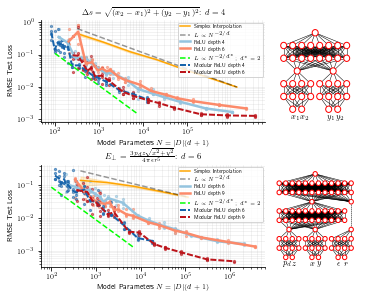

In [14]:
fig = plt.figure(figsize=(5.0, 4))
gs = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[0.7, 0.3])

# for rending equations properly, set manually
symbol_names = {
    Symbol('Ef'): 'E_\perp',
    Symbol('E_den'): 'E_{\text{den}}',
    Symbol('lambd'): '\lambda',
    Symbol('kb'): 'k_b'
}

optimal_dimension = {
    'I.10.7': 2,
    'I.30.5': 2,
    'I.8.14': 2, # 1 previously
    'I.39.22': 2,
    'I.44.4': 2,
    'I.12.11': 2, # 1 previously
    'II.6.15a': 2,
    'I.11.19': 2
}

# eqns = ["I.8.14", "II.6.15a"]
eqn = "I.8.14"

ax = fig.add_subplot(gs[0, 0])
# ax = plt.subplot(2, 2, 1)

fields = ['config', 'info']
query = {
    'status': 'COMPLETED',
    'config.eqn': eqn,
}
cursor = simplex_collection.find(query, fields)
results = list(cursor)
dimension = results[0]['info']['dimension']
sequence = [(r['config']['TRAIN_POINTS'] * (dimension + 1), r['info']['test']) for r in results]
xs = sorted(list(set([s[0] for s in sequence])))
means = np.array([np.mean([s[1] for s in sequence if s[0] == x]) for x in xs])
stds = np.array([np.std([s[1] for s in sequence if s[0] == x]) for x in xs])

min_simplex_mean = min(means)

plt.plot(xs, means, label='Simplex Interpolation', color='orange', alpha=1.0)
plt.fill_between(xs, means-stds, means+stds, color='orange', alpha=0.2)

x, y = xs[-1], means[-1]
C = y / np.power(x, -2 / dimension)
ys = C * np.power(xs, -2 / dimension)
plt.plot(xs, ys, '--', color='black', alpha=0.4, label="$L \propto N^{-2/d}$")

# colors = plt.cm.cool(np.linspace(0.1, 0.9, 3))
colors = [plt.cm.Blues(0.4), plt.cm.Reds(0.4)]
for i, depth in enumerate([4, 6]):
    fields = ['config', 'info', 'results']
    query = {
        'status': 'COMPLETED',
        'config.eqn': eqn,
        'config.lr': 0.001,
        'config.depth': depth,
        'config.activation': 'ReLU'
    }
    cursor = network_collection.find(query, fields)
    results = [x for x in cursor]
    if results:
        dimension = results[0]['info']['dimension']
        sequence = []
        for r in results:
            width, depth = r['config']['width'], r['config']['depth']
            p = parameters(width, depth, dimension)
            sequence.append((p, r['info']['test_at_min_train']))
        plt.scatter(*zip(*sequence), color=colors[i], s=5, alpha=0.6)
        xs = sorted(list(set([s[0] for s in sequence])))
#         print(len(xs))
        medians = np.array([np.median([s[1] for s in sequence if s[0] == x]) for x in xs])
        mins = np.array([np.min([s[1] for s in sequence if s[0] == x]) for x in xs])
        means = np.array([np.mean([s[1] for s in sequence if s[0] == x]) for x in xs])
        stds = np.array([np.std([s[1] for s in sequence if s[0] == x]) for x in xs])
        plt.plot(xs, medians, label=f'ReLU depth {depth}', color=colors[i], alpha=1.0, linewidth=2.5)
#         plt.fill_between(xs, means-stds, means+stds, color=colors[i], alpha=0.2)
#     if eqn in ['I.11.19', 'II.6.15a']:
#         x = [s[0] for s in sequence]
#         y = [s[1] for s in sequence]
#         x = np.log(x).reshape((-1, 1))
#         y = np.log(y)
#         reg = LinearRegression().fit(x, y)
#         slope = reg.coef_.item()
#         plt.text(xs[len(xs) // 2], 1.1*means[len(xs) // 2], "$ \propto N^{" + "{:.3f}".format(slope) + "}$")
if eqn in optimal_dimension:
    eff_dim = optimal_dimension[eqn]
#     x, y = xs[0], means[0]
    x = 100
    y = means[0]
    C = y / np.power(x, -2 / eff_dim)
#     end_x = np.power(min(means[-1], min_simplex_mean) / C, -eff_dim / 2)
    end_x = 7e3
    xs = np.linspace(x, end_x, 100)
    ys = 0.35 * C * np.power(xs, -2 / eff_dim)
    plt.plot(xs, ys, '--', color='lime', alpha=1.0, label=r"$L \propto N^{-2/{d^*}}; \ d^* = 2$", zorder=10)

# colors = plt.cm.cool(np.linspace(0.1, 0.9, 3))
colors = [plt.cm.Blues(0.8), plt.cm.Reds(0.8)]
for i, depth in enumerate([4, 6]):
    fields = ['config', 'info', 'results']
    query = {
        'status': 'COMPLETED',
        'config.eqn': eqn,
        'config.lr': 0.001,
        'config.depth': depth,
        'config.activation': 'ReLU'
    }
    cursor = modular_collection.find(query, fields)
    results = [x for x in cursor]
    if results:
        dimension = results[0]['info']['dimension']
        sequence = []
        for r in results:
            p = r['info']['parameters']
            sequence.append((p, r['info']['test_at_min_train']))
        xs = sorted(list(set([s[0] for s in sequence])))
        plt.scatter(*zip(*sequence), color=colors[i], s=5, alpha=0.6)
        means = np.array([np.mean([s[1] for s in sequence if s[0] == x]) for x in xs])
        medians = np.array([np.median([s[1] for s in sequence if s[0] == x]) for x in xs])
        mins = np.array([np.min([s[1] for s in sequence if s[0] == x]) for x in xs])
        stds = np.array([np.std([s[1] for s in sequence if s[0] == x]) for x in xs])
        plt.plot(xs, medians, label=f'Modular ReLU depth {depth}', color=colors[i], linestyle=(0, (3, 1)), alpha=1.0, linewidth=2)
#         plt.fill_between(xs, means-stds, means+stds, color=colors[i], alpha=0.2)
#         x = [s[0] for s in sequence if s[0] > 600 and s[0] < 5e4]
#         y = [s[1] for s in sequence if s[0] > 600 and s[0] < 5e4]
#         x = np.log(x).reshape((-1, 1))
#         y = np.log(y)
#         reg = LinearRegression().fit(x, y)
#         slope = reg.coef_.item()
#         plt.text(xs[len(xs) // 2], 1.1*means[len(xs) // 2], "$ \propto N^{" + "{:.3f}".format(slope) + "}$")

plt.tick_params(axis='x', which='major')
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.grid(True, which="both", linestyle='-', linewidth=0.5, alpha=0.3)

plt.yscale('log')
plt.xscale('log')
plt.xticks([100, 1000, 10000, 100000], fontsize=7)
plt.yticks(fontsize=7)
row = equations[equations['Equation'] == eqn]
eqn_formula = row['Formula'].item()
eqn_variables = [row[f'v{i}_name'].item() for i in range(1, dimension+1)]
output=row['Output'].item()
if output == 'Ef':
    output = 'E_\perp'
plt.xlabel(r"Model Parameters $N = |D|(d+1)$", fontsize=7)
plt.ylabel("RMSE Test Loss", fontsize=7)
if dimension == 1:
    full_formula = f"{eqn_formula}"
    plt.title(f"${output}={latex(parse_expr(full_formula), symbol_names=symbol_names)}$: $d = {dimension}$", fontsize=8)
else:
    if eqn == 'I.8.14':
            plt.title(r"$\Delta s=\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$:" +  f" $d = {dimension}$", fontsize=8)
    else:
        full_formula = f"{eqn_formula}"
        plt.title(f"${output}={latex(parse_expr(full_formula), symbol_names=symbol_names)}$: $d = {dimension}$", fontsize=8)

plt.legend(prop={'size': 5})


# eqns = ["I.8.14", "II.6.15a"]
eqn = "II.6.15a"

ax = fig.add_subplot(gs[1, 0])
# ax = plt.subplot(2, 2, 3)

fields = ['config', 'info']
query = {
    'status': 'COMPLETED',
    'config.eqn': eqn,
}
cursor = simplex_collection.find(query, fields)
results = list(cursor)
dimension = results[0]['info']['dimension']
sequence = [(r['config']['TRAIN_POINTS'] * (dimension + 1), r['info']['test']) for r in results]
xs = sorted(list(set([s[0] for s in sequence])))
means = np.array([np.mean([s[1] for s in sequence if s[0] == x]) for x in xs])
stds = np.array([np.std([s[1] for s in sequence if s[0] == x]) for x in xs])

min_simplex_mean = min(means)

plt.plot(xs, means, label='Simplex Interpolation', color='orange', alpha=1.0)
plt.fill_between(xs, means-stds, means+stds, color='orange', alpha=0.2)

x, y = xs[-1], means[-1]
C = y / np.power(x, -2 / dimension)
ys = C * np.power(xs, -2 / dimension)
plt.plot(xs, ys, '--', color='black', alpha=0.4, label="$L \propto N^{-2/d}$")

# colors = plt.cm.cool(np.linspace(0.1, 0.9, 3))
colors = [plt.cm.Blues(0.4), plt.cm.Reds(0.4)]
for i, depth in enumerate([6, 9]):
    fields = ['config', 'info', 'results']
    query = {
        'status': 'COMPLETED',
        'config.eqn': eqn,
        'config.lr': 0.001,
        'config.depth': depth,
        'config.activation': 'ReLU'
    }
    cursor = network_collection.find(query, fields)
    results = [x for x in cursor]
    if results:
        dimension = results[0]['info']['dimension']
        sequence = []
        for r in results:
            width, depth = r['config']['width'], r['config']['depth']
            p = parameters(width, depth, dimension)
            sequence.append((p, r['info']['test_at_min_train']))
        plt.scatter(*zip(*sequence), color=colors[i], s=5, alpha=0.6)
        xs = sorted(list(set([s[0] for s in sequence])))
#         print(len(xs))
        medians = np.array([np.median([s[1] for s in sequence if s[0] == x]) for x in xs])
        mins = np.array([np.min([s[1] for s in sequence if s[0] == x]) for x in xs])
        means = np.array([np.mean([s[1] for s in sequence if s[0] == x]) for x in xs])
        stds = np.array([np.std([s[1] for s in sequence if s[0] == x]) for x in xs])
        plt.plot(xs, medians, label=f'ReLU depth {depth}', color=colors[i], alpha=1.0, linewidth=2.5)
#         plt.fill_between(xs, means-stds, means+stds, color=colors[i], alpha=0.2)
#     if eqn in ['I.11.19', 'II.6.15a']:
#         x = [s[0] for s in sequence]
#         y = [s[1] for s in sequence]
#         x = np.log(x).reshape((-1, 1))
#         y = np.log(y)
#         reg = LinearRegression().fit(x, y)
#         slope = reg.coef_.item()
#         plt.text(xs[len(xs) // 2], 1.1*means[len(xs) // 2], "$ \propto N^{" + "{:.3f}".format(slope) + "}$")
if eqn in optimal_dimension:
    eff_dim = optimal_dimension[eqn]
#     x, y = xs[0], means[0]
    x = 100
    y = means[0]
    C = y / np.power(x, -2 / eff_dim)
#     end_x = np.power(min(means[-1], min_simplex_mean) / C, -eff_dim / 2)
    end_x = 7e3
    xs = np.linspace(x, end_x, 100)
    ys = 0.7 * C * np.power(xs, -2 / eff_dim)
    plt.plot(xs, ys, '--', color='lime', alpha=1.0, label=r"$L \propto N^{-2/{d^*}}; \ d^* = 2$", zorder=10)

# colors = plt.cm.cool(np.linspace(0.1, 0.9, 3))
colors = [plt.cm.Blues(0.8), plt.cm.Reds(0.8)]
for i, depth in enumerate([6, 9]):
    fields = ['config', 'info', 'results']
    query = {
        'status': 'COMPLETED',
        'config.eqn': eqn,
        'config.lr': 0.001,
        'config.depth': depth,
        'config.activation': 'ReLU'
    }
    cursor = modular_collection.find(query, fields)
    results = [x for x in cursor]
    if results:
        dimension = results[0]['info']['dimension']
        sequence = []
        for r in results:
            p = r['info']['parameters']
            sequence.append((p, r['info']['test_at_min_train']))
        xs = sorted(list(set([s[0] for s in sequence])))
        plt.scatter(*zip(*sequence), color=colors[i], s=5, alpha=0.6)
        means = np.array([np.mean([s[1] for s in sequence if s[0] == x]) for x in xs])
        medians = np.array([np.median([s[1] for s in sequence if s[0] == x]) for x in xs])
        mins = np.array([np.min([s[1] for s in sequence if s[0] == x]) for x in xs])
        stds = np.array([np.std([s[1] for s in sequence if s[0] == x]) for x in xs])
        plt.plot(xs, medians, label=f'Modular ReLU depth {depth}', color=colors[i], linestyle=(0, (3, 1)), alpha=1.0, linewidth=2)
#         plt.fill_between(xs, means-stds, means+stds, color=colors[i], alpha=0.2)
#         x = [s[0] for s in sequence if s[0] > 600 and s[0] < 5e4]
#         y = [s[1] for s in sequence if s[0] > 600 and s[0] < 5e4]
#         x = np.log(x).reshape((-1, 1))
#         y = np.log(y)
#         reg = LinearRegression().fit(x, y)
#         slope = reg.coef_.item()
#         plt.text(xs[len(xs) // 2], 1.1*means[len(xs) // 2], "$ \propto N^{" + "{:.3f}".format(slope) + "}$")

plt.tick_params(axis='x', which='major')
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.grid(True, which="both", linestyle='-', linewidth=0.5, alpha=0.3)

plt.yscale('log')
plt.xscale('log')
plt.xticks([100, 1000, 10000, 100000, 1000000], fontsize=7)
plt.yticks(fontsize=7)
row = equations[equations['Equation'] == eqn]
eqn_formula = row['Formula'].item()
eqn_variables = [row[f'v{i}_name'].item() for i in range(1, dimension+1)]
output=row['Output'].item()
if output == 'Ef':
    output = 'E_\perp'
plt.xlabel(r"Model Parameters $N = |D|(d+1)$", fontsize=7)
plt.ylabel("RMSE Test Loss", fontsize=7)
if dimension == 1:
    full_formula = f"{eqn_formula}"
    plt.title(f"${output}={latex(parse_expr(full_formula), symbol_names=symbol_names)}$: $d = {dimension}$", fontsize=8)
else:
    if eqn == 'I.8.14':
            plt.title(r"$\Delta s=\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$:" +  f" $d = {dimension}$", fontsize=8)
    else:
        full_formula = f"{eqn_formula}"
        plt.title(f"${output}={latex(parse_expr(full_formula), symbol_names=symbol_names)}$: $d = {dimension}$", fontsize=8)

plt.legend(prop={'size': 5})




ax = fig.add_subplot(gs[0, 1])
# ax = plt.subplot(2, 2, 2)
widths = [2, 4, 4, 1]
radius = 0.5
horizontal_gap = 1.5
vertical_gap = 2.0
circle_linewidth = 1.0

centers1 = []
for i, width in enumerate(widths):
    centers1.append(list())
    for j in range(width):
        centers1[i].append((-(width * horizontal_gap - horizontal_gap) / 2 + horizontal_gap * j, vertical_gap * i))
for i in range(len(widths)-1):
    for c0, c1 in product(centers1[i], centers1[i+1]):
        plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)
for row_centers in centers1:
    for center in row_centers:
        circle = plt.Circle(center, radius=radius, facecolor='white', edgecolor='red', linewidth=circle_linewidth)
        ax.add_patch(circle)
        
centers2 = []
for i, width in enumerate(widths):
    centers2.append(list())
    for j in range(width):
        centers2[i].append((-(width * horizontal_gap - horizontal_gap) / 2 + horizontal_gap * j + 6, vertical_gap * i))
for i in range(len(widths)-1):
    for c0, c1 in product(centers2[i], centers2[i+1]):
        plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)
for row_centers in centers2:
    for center in row_centers:
        circle = plt.Circle(center, radius=radius, facecolor='white', edgecolor='red', linewidth=circle_linewidth)
        ax.add_patch(circle)
widths = [2, 8, 8, 1]
centers3 = []
for i, width in enumerate(widths[1:]):
    centers3.append(list())
    for j in range(width):
        centers3[i].append((-(width * horizontal_gap - horizontal_gap) / 2 + horizontal_gap * j + 3, 8 + vertical_gap * i))
for i in range(len(widths)-2):
    for c0, c1 in product(centers3[i], centers3[i+1]):
        plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)
for row_centers in centers3:
    for center in row_centers:
        circle = plt.Circle(center, radius=radius, facecolor='white', edgecolor='red', linewidth=circle_linewidth)
        ax.add_patch(circle)  
        
# connect things up
for c1 in centers3[0]:
    c0 = centers1[-1][0]
    plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)
    c0 = centers2[-1][0]
    plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)

plt.text(-1, -1.5, r"$x_1$", fontsize=8)
plt.text(0.5, -1.5, r"$x_2$", fontsize=8)
plt.text(5, -1.5, r"$y_1$", fontsize=8)
plt.text(6.5, -1.5, r"$y_2$", fontsize=8)
plt.xlim(-5, 11)
plt.ylim(-2, 14)
ax.axis('off')


ax = fig.add_subplot(gs[1, 1])
# ax = plt.subplot(2, 2, 4)
widths = [2, 4, 4, 1]
radius = 0.5
horizontal_gap = 1.5
vertical_gap = 2.0
circle_linewidth = 1.0


centers1 = []
for i, width in enumerate(widths):
    centers1.append(list())
    for j in range(width):
        centers1[i].append((-(width * horizontal_gap - horizontal_gap) / 2 + horizontal_gap * j, vertical_gap * i))
for i in range(len(widths)-1):
    for c0, c1 in product(centers1[i], centers1[i+1]):
        plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)
for row_centers in centers1:
    for center in row_centers:
        circle = plt.Circle(center, radius=radius, facecolor='white', edgecolor='red', linewidth=circle_linewidth)
        ax.add_patch(circle)
        
centers2 = []
for i, width in enumerate(widths):
    centers2.append(list())
    for j in range(width):
        centers2[i].append((-(width * horizontal_gap - horizontal_gap) / 2 + horizontal_gap * j + 6, vertical_gap * i))
for i in range(len(widths)-1):
    for c0, c1 in product(centers2[i], centers2[i+1]):
        plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)
for row_centers in centers2:
    for center in row_centers:
        circle = plt.Circle(center, radius=radius, facecolor='white', edgecolor='red', linewidth=circle_linewidth)
        ax.add_patch(circle)

centers3 = []
for i, width in enumerate(widths):
    centers3.append(list())
    for j in range(width):
        if i == len(widths) - 1:
            centers3[i].append((centers3[i-1][-1][0], vertical_gap * i))
        else:
            centers3[i].append((-(width * horizontal_gap - horizontal_gap) / 2 + horizontal_gap * j + 12, vertical_gap * i))
for i in range(len(widths)-1):
    for c0, c1 in product(centers3[i], centers3[i+1]):
        plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)
for row_centers in centers3:
    for center in row_centers:
        circle = plt.Circle(center, radius=radius, facecolor='white', edgecolor='red', linewidth=circle_linewidth)
        ax.add_patch(circle)

widths = [2, 11, 11, 1]
centers4 = []
for i, width in enumerate(widths[1:]):
    centers4.append(list())
    for j in range(width):
        centers4[i].append((-(width * horizontal_gap - horizontal_gap) / 2 + horizontal_gap * j + 5.25, 8 + vertical_gap * i))
for i in range(len(widths)-2):
    for c0, c1 in product(centers4[i], centers4[i+1]):
        plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)
for row_centers in centers4:
    for center in row_centers:
        circle = plt.Circle(center, radius=radius, facecolor='white', edgecolor='red', linewidth=circle_linewidth)
        ax.add_patch(circle)  
        
# connect things up
for c1 in centers4[0]:
    c0 = centers1[-1][0]
    plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)
    c0 = centers2[-1][0]
    plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)

hanging_center = (centers3[2][-1][0], centers4[-1][0][1])
circle = plt.Circle(hanging_center, radius=radius, facecolor='white', edgecolor='red', linewidth=circle_linewidth)
ax.add_patch(circle) 
plt.plot([centers3[-1][0][0], hanging_center[0]], [centers3[-1][0][1], hanging_center[1]], color='black', zorder=-1, linewidth=0.5, linestyle=(0, (3, 1)))


widths = [2, 12, 12, 1]
centers5 = []
for i, width in enumerate(widths[1:]):
    centers5.append(list())
    for j in range(width):
        centers5[i].append((-(width * horizontal_gap - horizontal_gap) / 2 + horizontal_gap * j + 6, 14 + vertical_gap * i))
for i in range(len(widths)-2):
    for c0, c1 in product(centers5[i], centers5[i+1]):
        plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)
for row_centers in centers5:
    for center in row_centers:
        circle = plt.Circle(center, radius=radius, facecolor='white', edgecolor='red', linewidth=circle_linewidth)
        ax.add_patch(circle) 

# connect things up
for c1 in centers5[0]:
    c0 = centers4[-1][0]
    plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)
    c0 = hanging_center
    plt.plot([c0[0], c1[0]], [c0[1], c1[1]], color='black', zorder=-1, linewidth=0.5)
        
plt.text(-1.5, -1.7, r"$p_d$", fontsize=8)
plt.text(0.6, -1.7, r"$z$", fontsize=8)
plt.text(4.7, -1.7, r"$x$", fontsize=8)
plt.text(6.5, -1.7, r"$y$", fontsize=8)
plt.text(11, -1.7, r"$\epsilon$", fontsize=8)
plt.text(12.5, -1.7, r"$r$", fontsize=8)
plt.xlim(-5, 17)
plt.ylim(-2, 20)
ax.axis('off')



plt.tight_layout(pad=0.2)
plt.savefig("../final-figures/modularity-fairer-comparison-with-diagrams-normalized.pdf")